In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity.
What we will need:
- "imagenet_trained_model_weights.pkl"
- The betas and experiment stimuli
- A brain mask

In [13]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict

import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

In [47]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [8]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [9]:
trn_subjects = [1,]# 2, 5, 6]
val_subjects = [1,]# 2, 5, 6]

In [10]:
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'gnet_mpf' #'gnet_mpf_general'
model_dir = '%s_%s' % (model_name, timestamp)

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/"
output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: Feb-17-2021_1553


# Load the stimuli images
From the subjectwise image preparation

In [11]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

In [14]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

In [17]:
image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


## Examples

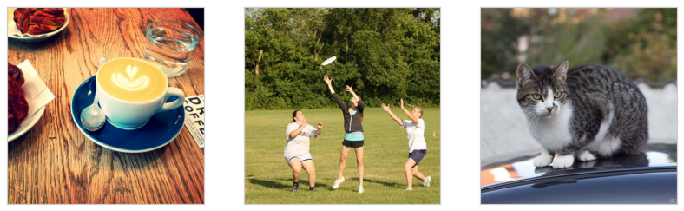

In [18]:
n = 6
plt.figure(figsize=(12,4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [22]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [23]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    #voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ncsnr_full = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
        
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 4627
1348 	: V1
1415 	: V2
1188 	: V3
676 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other


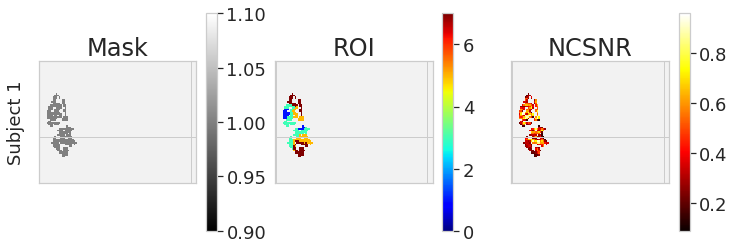

In [24]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    volume_ncsnr      = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+3)
    plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
    plt.title('NCSNR')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])

# Load voxels
Only run one of these cells
## Quick load (Load the voxel data block for these voxels only)

In [27]:
voxel_data_set = h5py.File(root_dir+'voxel_data_V1_4_part1.h5py', 'r')
#voxel_data_set = h5py.File(root_dir+'voxel_data_general.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()

voxel_data_1 = voxel_data_dict['voxel_data']
print (voxel_data_1.keys())

dict_keys(['1', '2', '5', '6'])


In [ ]:
voxel_data_set = h5py.File(root_dir+'voxel_data_V1_4_part2.h5py', 'r')
#voxel_data_set = h5py.File(root_dir+'voxel_data_general.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()

voxel_data_2 = voxel_data_dict['voxel_data']
print (voxel_data_2.keys())

In [ ]:
voxel_data_1.update(voxel_data_2)
print (voxel_data_1.keys())

In [ ]:
for s in trn_subjects:
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        if roi_name == 'V1':
            voxel_data[s] = voxel_data_1[s][:,roi_mask]
            print ("%s: %d \t: %s" % (s, np.sum(roi_mask), roi_name))

## Slow load from raw data

In [18]:
**
## Long version
from src.load_nsd import load_betas

voxel_data = {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/"%s
    voxel_data[s],_ = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask[s], up_to=-1)
    print ('----------------------------')
    print (voxel_data[s].shape)
    
save_stuff(root_dir + 'voxel_data_general', 
    flatten_dict({
   'voxel_mask': voxel_mask,
   'voxel_roi': voxel_roi,
   'voxel_idx': voxel_idx,
   'voxel_ncsnr': voxel_ncsnr,
   'voxel_data': voxel_data
            }))

SyntaxError: invalid syntax (<ipython-input-18-df5e723635cf>, line 1)

# Dataset split and unpacking or averaging
## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.

In [38]:
from src.load_nsd import image_feature_fn, data_split

data_size, nnv = {}, {}
val_stim_data,  trn_stim_data  = {}, {}
val_voxel_data, trn_voxel_data = {}, {}
val_stim_multi_trial_data, val_voxel_multi_trial_data = {}, {}

for k,s in enumerate(trn_subjects):
    data_size[s], nnv[s] = voxel_data['%s'%s].shape 
    print ('--------  subject %d  -------' % s)
    trn_stim_data[s], trn_voxel_data[s],\
    val_stim_single_trial_data[s], val_voxel_single_trial_data[s],\
    val_stim_multi_trial_data[s], val_voxel_multi_trial_data[s] = \
        data_split(image_feature_fn(image_data[s]), voxel_data['%s'%s], ordering, imagewise=False)

--------  subject 1  -------
Total number of voxels = 4627


- "stim_data" includes stimuli repeat. Takes more memory but it is easier to align with the single-trial voxel activity.

In [39]:
trn_stim_mean = sum([np.mean(trn_stim_data[s], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.47777534]]

  [[0.45386094]]

  [[0.4132076 ]]]]


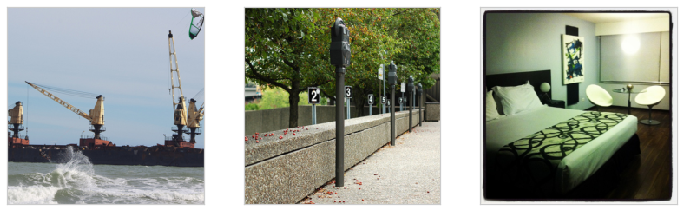

In [40]:
n = 6
plt.figure(figsize=(12,4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(trn_stim_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

---
# Model

In [159]:
from src.torch_joint_training_sequences import *
from src.torch_gnet import Encoder
from src.torch_mpf import Torch_LayerwiseFWRF

## Model instanciation

In [134]:
_log_act_fn = lambda _x: T.log(1 + T.abs(_x))*T.tanh(T.abs(_x))

In [135]:
shared_model = Encoder(trn_stim_mean, trunk_width=64).to(device)
rec, fmaps, h = shared_model(T.from_numpy(trn_stim_data[trn_subjects[0]][:20]).to(device))

subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=nnv[s], pre_nl=_log_act_fn, \
                 post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}

[20, 256, 25, 25]
[20, 256, 13, 13]


## Parameter count

In [136]:
for s,sp in subject_fwrfs.items():
    print ("--------- subject %d ----------"%s)
    for p in sp.parameters():
        print ("block size %-16s" % (list(p.size())))
        
param_count = 0
for w in shared_model.enc.parameters():
    param_count += np.prod(tuple(w.size()))
print ('')
print (param_count, "shared params")
total_nv = 0
for s,sp in subject_fwrfs.items():
    for p in sp.parameters():
        param_count += np.prod(tuple(p.size()))
    total_nv += nnv[s]
print (param_count // total_nv, "approx params per voxels")

--------- subject 1 ----------
block size [4627, 25, 25]  
block size [4627, 13, 13]  
block size [4627, 512]     
block size [4627]          

1034944 shared params
1530 approx params per voxels


## Load prefilters value

In [137]:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    
state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
        ### Rename dictionary keys to match new breakdown
pre_state_dict = {}
pre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')
pre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')
pre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')
pre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')
  
    
shared_model.pre.load_state_dict(pre_state_dict)
#for s,m in subject_models.items():
#    m.pre.load_state_dict(pre_state_dict)

<All keys matched successfully>

# Loss function, grad function, etc.

In [138]:
optimizer_net = optim.Adam([
        #{'params': shared_model.pre.parameters()},
        {'params': shared_model.enc.parameters()},
    ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)

subject_optimizer = {s: optim.Adam([
        {'params': sp.parameters()}
    ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}

subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}

In [147]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _smoothness_loss_fn(_rf, n):
    delta_x = T.sum(T.pow(T.abs(_rf[:, 1:]    - _rf[:, :-1]), n))
    delta_y = T.sum(T.pow(T.abs(_rf[:, :, 1:] - _rf[:, :, :-1]), n))
    return delta_x + delta_y

def _loss_fn(_ext, _con, _x, _v):
    _r = _model_fn(_ext, _con, _x)
    _err = T.sum((_r - _v)**2, dim=0)
    _loss = T.sum(_err)
    _loss += fpX(1e-1) * T.sum(T.abs(_con.w))
    return _err, _loss
    
def _training_fn(_ext, _con, _opts, xb, yb):
    for _opt in _opts:
        _opt.zero_grad()
        _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
        _loss.backward()
        _opt.step()
    return _err

def _holdout_fn(_ext, _con, xb, yb):
    _err,_ = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    return _err

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

def print_grads(_ext, _con, _params, _opt, xb, yb):
    _opt.zero_grad()
    _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))  
    _loss.backward()   
    for p in _params:
        prg = get_value(p.grad)     
        print ("%-16s : value=%f, grad=%f" % (list(p.size()), np.mean(np.abs(get_value(p))), np.mean(np.abs(prg))))
    print ('--------------------------------------')
    sys.stdout.flush()

In [140]:
subj = trn_subjects[0]
print_grads(shared_model, subject_fwrfs[subj],
            shared_model.enc.parameters(), 
            subject_optimizer[subj],
            trn_stim_data[subj][:20],
            trn_voxel_data[subj][:20])
print_grads(shared_model, subject_fwrfs[subj],
            subject_fwrfs[subj].parameters(), 
            subject_optimizer[subj],
            trn_stim_data[subj][:20],
            trn_voxel_data[subj][:20])

[128, 192, 3, 3] : value=0.029777, grad=0.049142
[128]            : value=0.000000, grad=0.140516
[192]            : value=1.000000, grad=0.069810
[192]            : value=0.000000, grad=0.227553
[128, 128, 3, 3] : value=0.033193, grad=0.045567
[128]            : value=0.000000, grad=0.072909
[128]            : value=1.000000, grad=0.055551
[128]            : value=0.000000, grad=0.182044
[128, 128, 3, 3] : value=0.033227, grad=0.042816
[128]            : value=0.000000, grad=0.073276
[128]            : value=1.000000, grad=0.066554
[128]            : value=0.000000, grad=0.150034
[128, 128, 3, 3] : value=0.033221, grad=0.023598
[128]            : value=0.000000, grad=0.075257
[128]            : value=1.000000, grad=0.037577
[128]            : value=0.000000, grad=0.136771
[128, 128, 3, 3] : value=0.033364, grad=0.040279
[128]            : value=0.000000, grad=0.066897
[128]            : value=1.000000, grad=0.064680
[128]            : value=0.000000, grad=0.177601
[128, 128, 3, 3] : v

# Training
IDEA: Use the more stable estimate from the holdout val cc to weight the voxels
Use a contiguity cost instead of sparsity for RF weights

In [149]:
batch_size = 100
num_epochs = 50
holdout_size = 3000

best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
    learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
        trn_stim_data, trn_voxel_data,
        num_epochs=num_epochs, batch_size=batch_size, holdout_size=holdout_size, masks=None, randomize=False)

/ : 100.0 %
  Epoch 1 of 50 took       82.405s
  training loss:               0.977159
  holdout loss (batch):        0.960474
  Subject 1: median (max) validation accuracy = 0.158 (0.497)
** Saving params with joint score = 0.158 **

/ : 100.0 %
  Epoch 2 of 50 took       83.099s
  training loss:               0.960283
  holdout loss (batch):        0.949987
  Subject 1: median (max) validation accuracy = 0.186 (0.599)
** Saving params with joint score = 0.186 **

/ : 100.0 %
  Epoch 3 of 50 took       83.376s
  training loss:               0.947490
  holdout loss (batch):        0.936579
  Subject 1: median (max) validation accuracy = 0.212 (0.657)
** Saving params with joint score = 0.212 **

/ : 100.0 %
  Epoch 4 of 50 took       83.582s
  training loss:               0.932939
  holdout loss (batch):        0.917959
  Subject 1: median (max) validation accuracy = 0.247 (0.679)
** Saving params with joint score = 0.247 **

/ : 100.0 %
  Epoch 5 of 50 took       83.731s
  training lo

/ : 100.0 %
  Epoch 38 of 50 took       83.652s
  training loss:               0.862585
  holdout loss (batch):        0.859361
  Subject 1: median (max) validation accuracy = 0.344 (0.735)

/ : 100.0 %
  Epoch 39 of 50 took       83.684s
  training loss:               0.862374
  holdout loss (batch):        0.861417
  Subject 1: median (max) validation accuracy = 0.342 (0.735)

/ : 100.0 %
  Epoch 40 of 50 took       83.727s
  training loss:               0.862364
  holdout loss (batch):        0.864482
  Subject 1: median (max) validation accuracy = 0.342 (0.735)

/ : 100.0 %
  Epoch 41 of 50 took       83.687s
  training loss:               0.861699
  holdout loss (batch):        0.859437
  Subject 1: median (max) validation accuracy = 0.343 (0.735)

/ : 100.0 %
  Epoch 42 of 50 took       83.684s
  training loss:               0.860936
  holdout loss (batch):        0.863049
  Subject 1: median (max) validation accuracy = 0.344 (0.736)

/ : 100.0 %
  Epoch 43 of 50 took       83.73

# Results

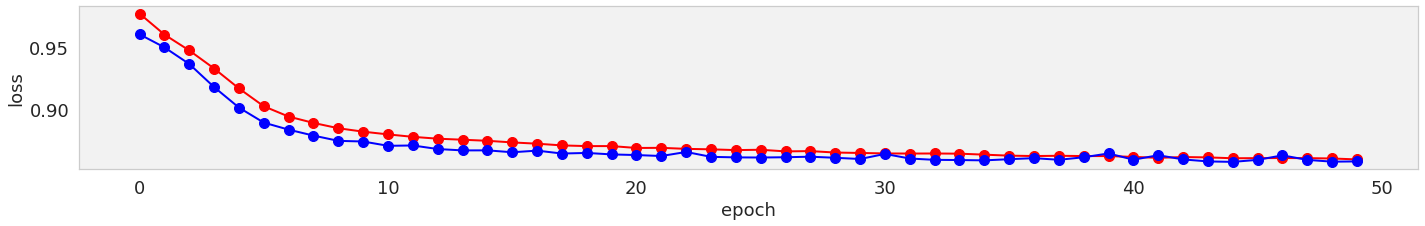

In [150]:
plt.figure(figsize=(24,3))
plt.plot(trn_hist, color='r', marker='o', ms=10, lw=2)
plt.plot(np.array(hold_hist), color='b', marker='o', ms=10, lw=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()

No handles with labels found to put in legend.


Text(0.5, 0, 'epoch')

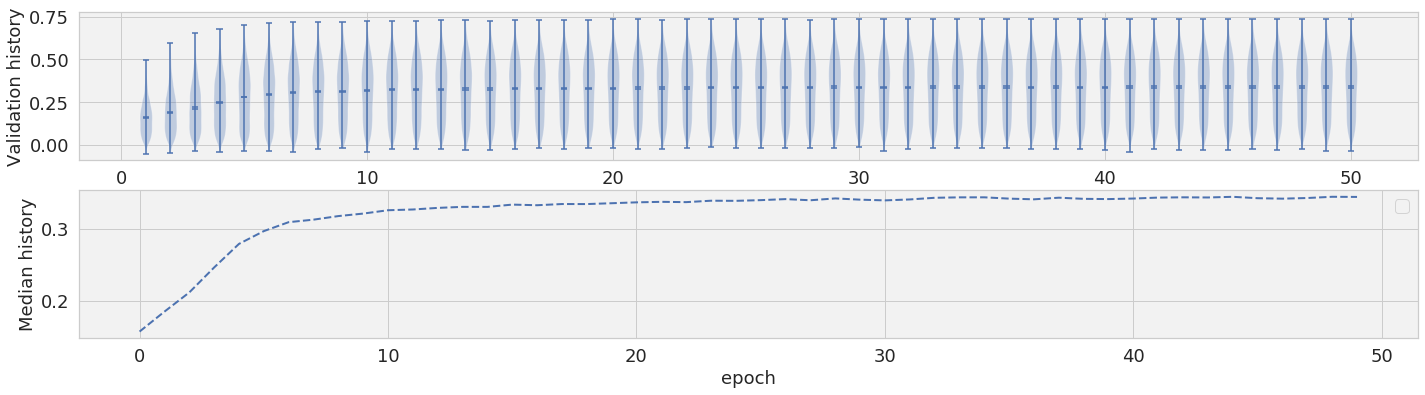

In [151]:
plt.figure(figsize=(24,6))
plt.subplot(2,1,1)
for s,cc in hold_cc_hist.items():
    plt.gca().violinplot(np.nan_to_num(np.array(cc)).T, showmeans=True, showmedians=True, showextrema=True)
plt.ylabel('Validation history')
plt.subplot(2,1,2)
for s in hold_cc_hist.keys():
    p=plt.plot([np.median(cc) for cc in hold_cc_hist[s]], lw=2, linestyle='--')
plt.legend()
plt.ylabel('Median history')
plt.xlabel('epoch')

---
## Final validation accuracy

In [152]:
val_voxel = {s: val_voxel_single_trial_data[s] for s in val_voxel_single_trial_data.keys()}
shared_model.load_state_dict(best_params['enc'])
shared_model.eval() 
for s,sd in subject_fwrfs.items():
    sd.load_state_dict(best_params['fwrfs'][s])
    sd.eval() 

batch_size = 50
subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, val_stim_single_trial_data, val_voxel, batch_size)
joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

best joint score = 0.345
best joint val cc = 0.358
subject 1: val cc = 0.358


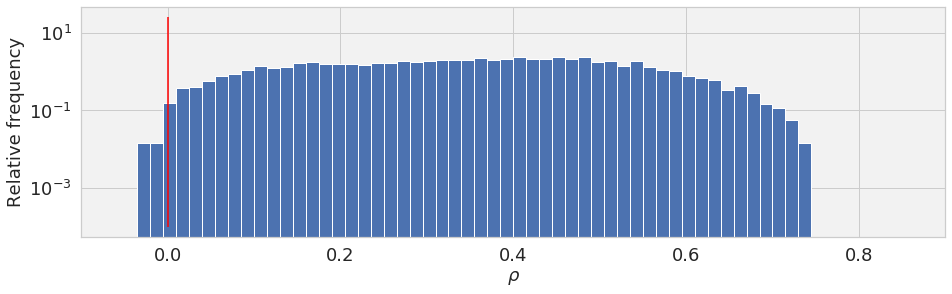

In [153]:
print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_val_cc))
for s,v in subject_val_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

# Save final parameters

In [154]:
#subj = trn_subjects[0] # for s in val_subjects
subject_dir = output_dir #+ 'S%02d/'%subj

torch.save({
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_size': holdout_size,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask
            }, subject_dir+'model_params')

In [163]:
n_resample = 64
subject_resample_val_cc = {}

for s in val_voxel_data.keys():
    print ('sampling subject %d'%s)
    subject_resample_val_cc[s] = cc_resampling_with_replacement(_pred_fn, shared_model, subject_fwrfs[s], val_stim_single_trial_data[s], val_voxel_single_trial_data[s], batch_size, n_resample)

sampling subject 1


100%|██████████| 64/64 [00:44<00:00,  1.43it/s]


best_joint_cc_score: 0.345
score mean = 0.3584, std.dev = 0.0037
Subject 1 median cc mean = 0.3584, std.dev = 0.0037


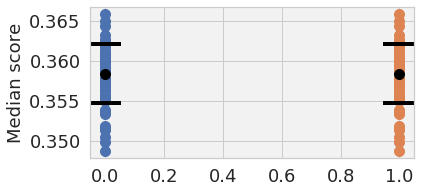

In [164]:
print ('best_joint_cc_score: %.3f' % best_joint_cc_score)
fig=plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.2, bottom=0.60, right=.95, top=.95, wspace=0., hspace=0.)
val_score_samples = [np.median(np.concatenate([ccs[i] for s,ccs in subject_resample_val_cc.items()], axis=0))\
    for i in range(n_resample)]
print ('score mean = %.04f, std.dev = %.04f'% (np.mean(val_score_samples),  np.std(val_score_samples)))
plt.plot([0,]*len(val_score_samples), val_score_samples, linestyle='None', marker='o', ms=10)
plt.errorbar(x=[0,], y=[np.mean(val_score_samples),], yerr=[np.std(val_score_samples),], marker='o',\
    color='k', ms=10, elinewidth=4,capsize=16, capthick=4)

for k,(s,ccs) in enumerate(subject_resample_val_cc.items()): 
    mcc = [np.median(cc) for cc in ccs]
    print ('Subject %s median cc mean = %.04f, std.dev = %.04f'% (s, np.mean(mcc), np.std(mcc)))
    plt.plot([k+1,]*len(mcc), mcc, linestyle='None', marker='o', ms=10)
    plt.errorbar(x=[k+1,], y=[np.mean(mcc),], yerr=[np.std(mcc),], marker='o',\
             color='k', ms=10, elinewidth=4,capsize=16, capthick=4)
    plt.ylabel('Median score')

# Subject-wise analysis

In [155]:
subj = 1 # for s in val_subjects
subject_dir = output_dir + 'S%02d/'%subj

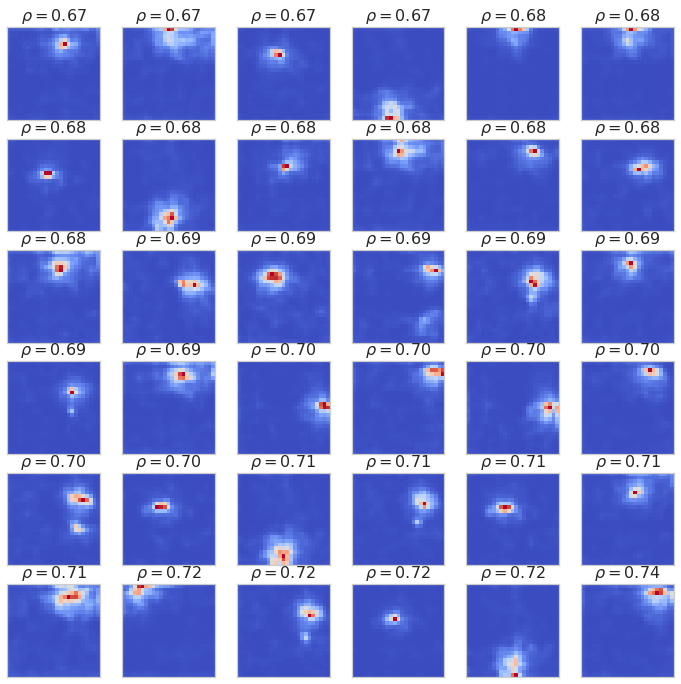

In [156]:
from matplotlib import cm
def pooling_fn(x):
    return np.exp(x) / np.sum(np.exp(x), axis=(1,2), keepdims=True)

vidxes = np.argsort(subject_val_cc[subj])
vox = vidxes[-36:] # np.arange(49) #
n_x = int(np.floor(np.sqrt(len(vox))))
n_y = int(np.ceil(len(vox)/n_x))+1
fig2a=plt.figure(figsize=(2*n_x,2*n_y))
for k,v in enumerate(vox):
    plt.subplot(n_y,n_x,k+1)
    plt.imshow(pooling_fn(get_value(subject_fwrfs[subj].rfs[0])[v,np.newaxis])[0], interpolation='None', cmap=cm.coolwarm, origin='upper') # vidxes[-100:]  
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title(r'$\rho=$%.2f'% subject_val_cc[subj][v], fontsize=16)

In [143]:
filename = subject_dir + "subj%02d_rf0_sample%s"  % (subj, saveext)
fig2a.patch.set_alpha(0.)
fig2a.savefig(filename, **savearg)
plt.close()

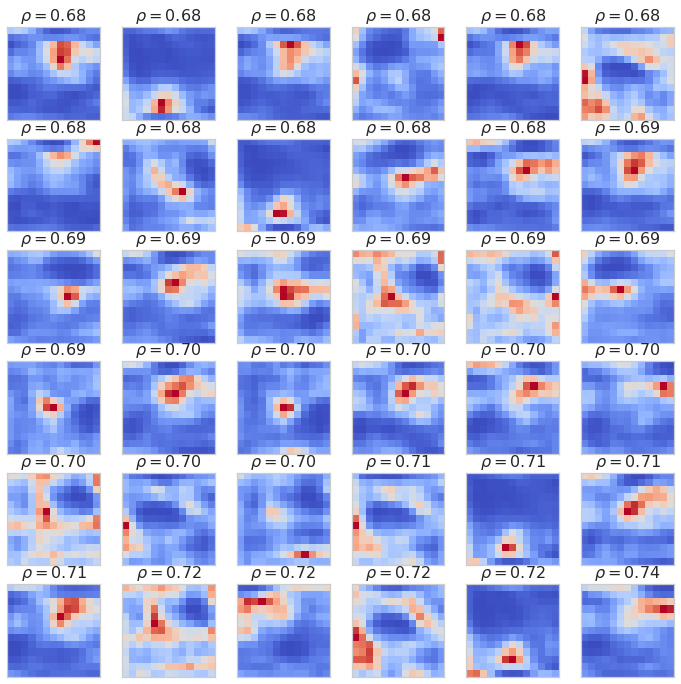

In [98]:
fig2b=plt.figure(figsize=(2*n_x,2*n_y))
for k,v in enumerate(vox):
    plt.subplot(n_y,n_x,k+1)
    plt.imshow(pooling_fn(get_value(subject_fwrfs[subj].rfs[1])[v,np.newaxis])[0], interpolation='None', cmap=cm.coolwarm, origin='upper') # vidxes[-100:]  
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title(r'$\rho=$%.2f'% subject_val_cc[subj][v], fontsize=16)

In [145]:
filename = subject_dir + "subj%02d_rf1_sample%s"  % (subj, saveext)
fig2b.patch.set_alpha(0.)
fig2b.savefig(filename, **savearg)
plt.close()

---
# Model parameter reload

In [77]:
**
checkpoint = torch.load(output_dir + 'model_params')
print (checkpoint.keys())
best_params = checkpoint['best_params']

shared_model.pre.load_state_dict(best_params['pre'])
shared_model.enc.load_state_dict(best_params['enc'])
shared_model.eval()
#shared_model.dec.load_state_dict(best_params['dec'])
for s,sd in subject_fwrfs.items():
    sd.load_state_dict(best_params['fwrfs'][s])
    sd.eval()

SyntaxError: invalid syntax (<ipython-input-77-9d809762fee1>, line 1)

In [83]:
import copy
weight_init_value = {
    'enc': copy.deepcopy(shared_model.state_dict()),
    'fwrfs': {s: copy.deepcopy(sd.state_dict()) for s,sd in subject_fwrfs.items()},
    'enc_opt': copy.deepcopy(optimizer_net.state_dict()),
    'fwrfs_opt': {s: copy.deepcopy(sd.state_dict()) for s,sd in subject_optimizer.items()}
    }

## Initialization

In [84]:
################################################
def subject_training_pass(x, v, batch_size):
    trn_err = float(0)
    for s, xb, vb in iterate_subject_minibatches(x, v, batch_size):
        trn_err += get_value(T.mean(training_fn(s, xb, vb))) 
    return trn_err / sum(len(xx) for s,xx in x.items())

#################################################
def holdout_fn(s, xb, yb, wvb=None):
    err,_ = loss_fn(s, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    return err
def subject_holdout_pass(x, v, batch_size):
    #val_err = np.zeros(shape=(v.shape[1]), dtype=v.dtype)
    val_err = float(0)
    for s, xb, vb in iterate_subject_minibatches(x, v, batch_size):
        val_err += get_value(T.mean(holdout_fn(s, xb, vb)))
    return val_err / sum(len(xx) for s,xx in x.items())

#################################################
def subject_pred_pass(s, x, v, batch_size):
    pred = np.zeros_like(v)
    for rb,_ in iterate_range(0, len(x), batch_size):
        pred[rb] = get_value(validation_fn(s, x[rb]))
    return pred
def validation_fn(s, xb):
    _,r,_ = model_fn(s, T.from_numpy(xb).to(device))
    return r
def subject_validation_pass(s, x, v, batch_size):
    val_cc  = np.zeros(shape=(v.shape[1]), dtype=v.dtype)
    val_pred = subject_pred_pass(s, x, v, batch_size)
    for i in range(v.shape[1]):
        val_cc[i] = np.corrcoef(v[:,i], val_pred[:,i])[0,1]                  
    return val_cc

#################################################
def random_split(stim, voxel, subselect, trn_size, holdout_size, random=False):
    idx = np.arange(len(stim))
    if random:
        np.random.shuffle(idx)  
        idx = idx[:trn_size]
        return stim[idx[:-holdout_size]], voxel[:,subselect][idx[:-holdout_size]], \
               stim[idx[-holdout_size:]], voxel[:,subselect][idx[-holdout_size:]]
    else: # this prevents a dumb copy of the memory buffers
        return stim[:-holdout_size], voxel[:,subselect][:-holdout_size], \
               stim[-holdout_size:], voxel[:,subselect][-holdout_size:]         
    
def learn_params_(stims, voxels, num_epochs, batch_size, holdout_size, trn_size=None, masks=None, randomize=False):
    '''assumes shared_model and subject_fwrfs in global scope'''
    import copy
    if masks is None:
        masks = {s: np.ones(shape=(v.shape[1]), dtype=bool) for s,v in voxels.items()}    
        
    trn_stim, trn_sub_voxel, hld_stim, hld_sub_voxel = {}, {}, {}, {}
    for k,s in enumerate(voxels.keys()):
        trn_stim[s], trn_sub_voxel[s], hld_stim[s], hld_sub_voxel[s] = \
            random_split(stims[s], voxels[s], masks[s], trn_size=trn_size if trn_size is not None else len(stims[s]), \
                         holdout_size=holdout_size, random=randomize)
   
    hold_hist, trn_hist = [], []
    hold_cc_hist = {s: [] for s in trn_subjects}
    val_cc_hist = {s: [] for s in trn_subjects}
    best_joint_cc_score = float(0)
    best_params = {}
    best_epoch = 0
    
    for epoch in range(num_epochs):
        ##
        ## Training pass for this subject
        ##
        start_time = time.time()
        shared_model.train()
        [subject_fwrfs[s].train() for s in voxels.keys()]
        trn_err = subject_training_pass(trn_stim, trn_sub_voxel, batch_size)
        trn_hist += [trn_err,]
        ###
        shared_model.eval()
        [subject_fwrfs[s].eval() for s in voxels.keys()]
        hold_err = subject_holdout_pass(hld_stim, hld_sub_voxel, batch_size)
        hold_hist += [hold_err,]
        ##    
        ## Do a validation pass to monitor the evolution
        ##
        print("\n  Epoch {} of {} took       {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:               {:.6f}".format(trn_err))
        print("  holdout loss (batch):        {:.6f}".format(hold_err))       
        ##
        joint_cc = []
        for s in voxels.keys():
            hold_cc  = subject_validation_pass(s, hld_stim[s], hld_sub_voxel[s], batch_size)
            joint_cc += [np.copy(hold_cc),]
            hold_cc_hist[s] += [np.copy(hold_cc),]
            print("  Subject {}: median (max) validation accuracy = {:.3f} ({:.3f})".format(s, np.median(np.nan_to_num(hold_cc)), np.max(np.nan_to_num(hold_cc))))
        ##
        ## Save parameter snapshot
        ##
        joint_cc_score = np.median(np.nan_to_num(np.concatenate(joint_cc)))
        if joint_cc_score>best_joint_cc_score:
            print ("** Saving params with joint score = {:.3f} **".format(joint_cc_score))
            best_joint_cc_score = joint_cc_score
            best_epoch = epoch
            best_params = {
                'enc': copy.deepcopy(shared_model.state_dict()),
                'fwrfs': {s: copy.deepcopy(sd.state_dict()) for s,sd in subject_fwrfs.items()}
                }
        print ("")
        sys.stdout.flush()
    ###
    final_params = {
        'enc': copy.deepcopy(shared_model.state_dict()),
        'fwrfs': {s: copy.deepcopy(sd.state_dict()) for s,sd in subject_fwrfs.items()}
        }    
    
    return best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score

def validation_(stims, voxels, batch_size):
    subject_val_cc = {}
    shared_model.eval()
    for s in voxels.keys():
        subject_fwrfs[s].eval()            
        val_cc = subject_validation_pass(s, stims[s], voxels[s], batch_size) 
        subject_val_cc[s] = np.nan_to_num(val_cc)    
    return subject_val_cc

def sample_with_replacement(indices):
    return indices[np.random.randint(len(indices), size=len(indices))]    
def cc_resampling_with_replacement(s, x, v, batch_size, n_resample=1):
    pred = subject_pred_pass(s, x, v, batch_size)
    cc = np.zeros(shape=(v.shape[1]), dtype=fpX)
    ccs = []
    for rs in tqdm(range(n_resample)):
        res = sample_with_replacement(np.arange(len(pred)))
        data_res = v[res]
        pred_res = pred[res]
        for i in range(sub_nv[s]):
            cc[i] = np.corrcoef(data_res[:,i], pred_res[:,i])[0,1]  
        ccs += [np.nan_to_num(cc)]
    return ccs

In [86]:
print_grads(trn_subjects[0],
            trn_stim_data[trn_subjects[0]][:20],
            trn_voxel_data[trn_subjects[0]][:20])

--------------------------------------
[128, 192, 3, 3] : value=0.029720, grad=0.054697
[128]            : value=0.000000, grad=0.138809
[192]            : value=1.000000, grad=0.079627
[192]            : value=0.000000, grad=0.222008
[128, 128, 3, 3] : value=0.033297, grad=0.048442
[128]            : value=0.000000, grad=0.087342
[128]            : value=1.000000, grad=0.075418
[128]            : value=0.000000, grad=0.203617
[128, 128, 3, 3] : value=0.033217, grad=0.047874
[128]            : value=0.000000, grad=0.071986
[128]            : value=1.000000, grad=0.073127
[128]            : value=0.000000, grad=0.162101
[128, 128, 3, 3] : value=0.033312, grad=0.028360
[128]            : value=0.000000, grad=0.072001
[128]            : value=1.000000, grad=0.046451
[128]            : value=0.000000, grad=0.145585
[128, 128, 3, 3] : value=0.033292, grad=0.043484
[128]            : value=0.000000, grad=0.071837
[128]            : value=1.000000, grad=0.074427
[128]            : value=0.000

## Objective definition

In [69]:
def smoothness_loss_fn(_rf, n):
    delta_x = T.sum(T.pow(T.abs(_rf[:, 1:]    - _rf[:, :-1]), n))
    delta_y = T.sum(T.pow(T.abs(_rf[:, :, 1:] - _rf[:, :, :-1]), n))
    return delta_x + delta_y
def rec_loss_fn(_x, _y):
    return torch.sum(torch.sum((_x-_y)**2, axis=0))
def huber(r, v, delta=1.0):
    d = T.flatten(r - v)
    m = d<=delta
    return T.reshape((d**2 * m + delta * (2*d - delta) * ~m), r.shape)
def vox_loss_fn(s, r, v, nu=0.5, delta=1.):
    #err = T.sum(huber(r, v, delta), dim=0)
    err = T.sum((r - v)**2, dim=0)
    # squared correlation coefficient with 'leak'
    cr = r - T.mean(r, dim=0, keepdim=True)
    cv = v - T.mean(v, dim=0, keepdim=True)
    wgt = T.clamp(T.pow(T.mean(cr*cv, dim=0), 2) / ((T.mean(cr**2, dim=0)) * (T.mean(cv**2, dim=0)) + 1e-6), min=nu, max=1).detach()
 
    weighted_err = wgt * err # error per voxel
    loss = T.sum(weighted_err) / T.mean(wgt)

    return err, loss
def loss_fn(s, x, v):
    y, r, h = model_fn(s, x)
    err, loss = vox_loss_fn(s, r, v, nu=0.1, delta=.5)
    loss += fpX(1e-1) * T.sum(T.abs(subject_fwrfs[s].w))
    #loss += fpX(1e-1) * smoothness_loss_fn(subject_fwrfs[s].rfs[0], 1)
    #loss += fpX(1e-1) * smoothness_loss_fn(subject_fwrfs[s].rfs[1], 1)
    #loss += fpX(1e-3) * rec_loss_fn(x, y)
    return err, loss

## Optimizer instanciation

In [82]:
optimizer_net = optim.Adam([
        #{'params': shared_model.pre.parameters()},
        {'params': shared_model.enc.parameters()},
    ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)

subject_optimizer = {s: optim.Adam([
        {'params': sp.parameters()}
    ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}

subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}

def training_fn(s, xb, yb):
    ## net param update
    optimizer_net.zero_grad()
    err, loss = loss_fn(s, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    loss.backward()
    optimizer_net.step()
    ## connection model
    subject_optimizer[s].zero_grad()
    err, loss = loss_fn(s, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    loss.backward()
    subject_optimizer[s].step()
    return err